In [52]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils.multiclass import unique_labels
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from features import featureExtractionPipeline
from tqdm import tqdm_notebook as tqdm
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy.stats import moment
import statsmodels.api as sm
from sklearn.svm import SVC
import pandas as pd
import numpy as np
import pyeeg
import glob
import pywt
import os

from sklearn.neighbors import KNeighborsClassifier

In [2]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]



    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [3]:
feature_array = []
#files = glob.glob('../data/2colours_muse_transition/*.csv')
#files = glob.glob('../data/2colours_muse_onlycolor/*.csv')
files = glob.glob('../data/2colourswifi_transition/*.csv')

In [40]:
if not os.path.exists('../objects/feature_array.npy'):
    for file in tqdm(files):
        try:
            data = pd.read_csv(file,header=None)
            channels = data[:-1]
            label = data.iloc[-1]
            label = int(list(set(label))[0])
            for i in range(len(channels)):
                channel = channels.iloc[i].values
                channel_features = featureExtractionPipeline(channel,fs=1000).runPipeline()
                feature_array.append([channel_features,label])
        except Exception as e:
            print(e,'\n',file)
else:
    feature_array = np.load('../objects/feature_array.npy')

In [44]:
feature_array = np.array(feature_array)
data = feature_array[:,0]
labels = feature_array[:,1]

3088

In [5]:
feature_array = feature_array.tolist()

In [6]:
X = []
y = []
for i in feature_array:
    X.append(i[0])
    y.append(i[1])

In [7]:
X = np.nan_to_num(X)
X_scaled = StandardScaler().fit_transform(X)

In [8]:
mod = sm.OLS(y, X)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     3.480
Date:                Thu, 29 Aug 2019   Prob (F-statistic):           1.99e-09
Time:                        01:30:42   Log-Likelihood:                -2192.8
No. Observations:                3088   AIC:                             4444.
Df Residuals:                    3059   BIC:                             4619.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.2669      0.235      1.134      0.2

In [55]:
new_X = []
feature_to_consider = [3,5,6,8,17,21,24,25]
for i in X:
    temp = []
    for j in feature_to_consider:
        temp.append(i[j-1])
    new_X.append(temp)

In [56]:
x_train,x_test,y_train,y_test = train_test_split(new_X,y)

In [57]:
model = KNeighborsClassifier(n_neighbors = 3)
model.fit(x_train,y_train)
pred = model.predict(x_test)
precision_recall_fscore_support(pred,y_test)

(array([0.51958225, 0.55526992]),
 array([0.53494624, 0.54      ]),
 array([0.52715232, 0.54752852]),
 array([372, 400]))

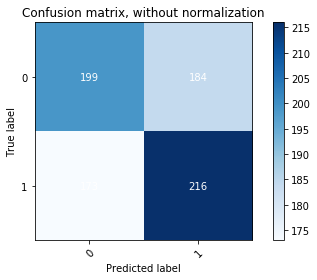

In [58]:
plot_confusion_matrix(y_test, model.predict(x_test), [0,1],
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues)

AttributeError: 'KNeighborsClassifier' object has no attribute 'feature_importances_'